# True DiT

-Incorporates conditional information via AdaLN-Zero  
-Remark: this adds many more parameters, e.g. 6.5 to 9.7M  
-Appears to perform visibly better—scroll down for just generations after  epoch 5

In [ ]:
N_CLASS = 10
LABEL = 0 ## when generating images of a single digit

UNCOND_LABEL = N_CLASS ### unconditional token. Note this will yield n_class <- n_class + 1
## cannot use -1, which gives nn.Embedding error
LABEL_DROPOUT = 0.2

################### regular CFG
# TRAIN_GUIDANCE = 5
SAMPLE_GUIDANCE = 5

#### 5-10 all look good
# 0 = unconditional
# 1 = conditional
# > 1 = guidance

In [ ]:
## Label dropout util fn to employ in train function, applied in-place
def drop_label(labels, p):
  """
  labels = batch of conditional labels
  p = dropout prob
  """
  mask = np.random.rand(*labels.shape) < p
  labels[mask] = UNCOND_LABEL

In [ ]:
## Transformer architecture
N_HEAD = 32
N_LAYER = 8
N_EMBD = 256
# N_KV_HEAD = 4
N_FF = N_EMBD * 4

PATCH_SIZE = 4

## Diffusion architecture
T_MAX = 400
BETA_MIN = 1e-4
BETA_MAX = 0.02
SCHEDULE = 'linear'

## Data and training
DATASET = 'MNIST'
BATCH_SIZE = 64
LR = 1e-3

IMG_CHANNELS = (1 if DATASET == 'MNIST' else 3)
IMG_SIZE = (28 if DATASET == 'MNIST' else 32)

## Batch/step-level hyperparameters
EPOCHS = 100
SAVE_EVERY = int(EPOCHS*0.05) # save model every x epochs
GENERATE_EVERY = int(EPOCHS*0.05) # generate image from model every x epochs

### ––––TEMP–––– ###
SAVE_EVERY = 1
GENERATE_EVERY = 1
### ––––TEMP–––– ###

## Step-level hyperparameters
PRINT_EVERY = 100 # print loss every x steps

## Model loading
CHECKPOINT = True # False
LOAD_EPOCH = 29 # None

START_EPOCH = LOAD_EPOCH if LOAD_EPOCH is not None else 0

# path = '/content/drive/MyDrive/DiT'
path = '/content/drive/Shareddrives/DSU Better Transformer/DIT'

MODEL_NAME = f"ada_ln_dit_cfg_{N_LAYER}_LAYERs_{N_HEAD}_HEADs_{N_EMBD}_EMBD_DIM_{T_MAX}_TMAX_{DATASET}"
# MODEL_NAME = f"dit_cfg_{N_LAYER}_LAYERs_{N_HEAD}_HEADs_{N_EMBD}_EMBD_DIM_{T_MAX}_TMAX_{SCHEDULE}_{DATASET}"
print("Model Name:", MODEL_NAME)
print(f'Model will be saved every {SAVE_EVERY} epochs, and will generate images every {GENERATE_EVERY} epochs')

Model Name: ada_ln_dit_cfg_8_LAYERs_32_HEADs_256_EMBD_DIM_400_TMAX_MNIST
Model will be saved every 1 epochs, and will generate images every 1 epochs


# Imports

In [ ]:
%%capture
!pip install einops
# !pip install torchinfo

In [ ]:
import json
import os
import random
import re
import time

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

from einops import pack, rearrange
from IPython.display import HTML
from PIL import Image
from torch.backends.cuda import sdp_kernel, SDPBackend
from torch.utils.data import DataLoader
# from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [ ]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed) # if multi-GPU
    torch.backends.cudnn.deterministic=True # only applies to CUDA convolution operations
    torch.backends.cudnn.benchmark = False
    # usually CuDNN has heuristics as to which algorithm to pick. cudnn.benchmark benchmarks several algorithms and picks the fastest
    # often helpful if your input shapes are fixed and not changing a lot during training
    # however, this means it may pick a different algorithm even when the deterministic flag is set.
    # As such it is good practice to turn off cudnn.benchmark when turning on cudnn.deterministic

set_seed()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# # for flash attention
# backend_map = {
#     SDPBackend.MATH: {"enable_math": True, "enable_flash": False, "enable_mem_efficient": False},
#     SDPBackend.FLASH_ATTENTION: {"enable_math": False, "enable_flash": True, "enable_mem_efficient": False},
#     SDPBackend.EFFICIENT_ATTENTION: {
#         "enable_math": False, "enable_flash": False, "enable_mem_efficient": True}
# }

# Data

In [ ]:
transform_fn = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors and [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # [0,1] -> [-1, 1]
])

# Download and load data
if DATASET == 'CIFAR-10':
    train_data = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_fn
    )
    val_data = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_fn
    )
elif DATASET == 'MNIST':
    train_data = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform_fn
    )
    val_data = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform_fn
    )

# Create data loaders
train_loader = DataLoader(train_data,
                          shuffle=True,
                          batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data,
                        shuffle=True,
                        batch_size=BATCH_SIZE)

# Diffusion

In [ ]:
# extract relevant alpha/beta/etc. given timestep tensor t, reshape for compatibility with image x
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
# e.g. if x_shape is [batch_size, 3, 128, 128], then we get an output of [batch_size, 1, 1, 1]

In [ ]:
class DDPM(nn.Module):
    def __init__(self, t_max, beta_min, beta_max, schedule='linear', s=0.008, eta=1):

        assert schedule in ['linear', 'cosine'], "beta variance schedule must be `linear` or `cosine`"
        if schedule == 'cosine':
          assert s > 0, "cosine offset must be positive"

        super().__init__()
        ## init variance schedule, alphas, etc.
        self.t_max = t_max
        self.beta_min, self.beta_max = beta_min, beta_max
        self.eta = eta # for DDIM-style sampling if you enable. (1 = DDPM equivalent, 0 = DDIM proper)

        ## linear schedule
        if schedule == 'linear':
            self.betas = torch.linspace(beta_min, beta_max, t_max)
        ## cosine schedule
        elif schedule == 'cosine':
            # https://arxiv.org/abs/2102.09672
            # β_t = 1 - ( a-bar_t / a-bar_{t-1}), where
            # a-bar_t = f(t) / f(0), where
            # f(t) = cos^2([π/2] * [((t/T) + s) /  (1+s)])
            steps = t_max + 1
            t = torch.linspace(0, t_max, steps)
            ft = torch.cos(((t / t_max) + s) / (1 + s) * torch.pi * 0.5) ** 2
            alphas_bar_t = ft / ft[0]
            betas = 1 - (alphas_bar_t[1:] / alphas_bar_t[:-1])
            self.betas = torch.clip(betas, beta_min, beta_max) ### changed from 0.9999 to beta_max
            ## observation: mixing cosine schedule w/ max 0.999 (rather than 0.02 max) is incompatible with current sampling code it seems
            # (at least with ε-prediction rather than x0), yields grey blurry images when sampling

        ## to parameterize p and q
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)

    def forward(self, x0, t):
        ## i.e. q_sample
        noise = torch.randn_like(x0)

        # recall xt  = √(a-bar_t)x0 + √(1-a-bar_t)ε
        # t will be a tensor when .forward is called, no need to create tensor version
        alpha_bar = extract(self.alphas_bar, t, x0.shape)
        mean = x0 * alpha_bar.sqrt()
        std = (1-alpha_bar).sqrt()
        xt = mean + std * noise
        return xt, noise

    def backward(self, xt, model, labels, steps=None,
                 method='conditional', scale=SAMPLE_GUIDANCE, neg_label=UNCOND_LABEL):

        assert method in ['conditional', 'cfg'], "method must be `conditional` or `cfg`"
        if method == 'cfg':
            assert isinstance(scale, (int, float, np.integer)) and scale >= 0, 'scale must be a float greater than or equal to 0'

        if steps is None:
            steps = self.t_max

        ## i.e. p_sample in a loop
        ## for i in reversed(range(0, timesteps)
        ## send through model, convert predicted noise (eta) into posterior mean, return mean + std*noise
        ## if last timestep, just return mean

        ## fix variances simply as beta_t, like in paper, rather than learn

        # note labels is a tensor already

        B, C, H, W = xt.shape

        ## list of how the images look after each denoising step
        xt_denoised_list = []

        if method == 'cfg':
          neg_labels = torch.full((B,), neg_label, dtype=torch.long, device=device) ## unconditional label, or custom negative prompt

        for t in reversed(range(0, steps)):

            t_tensor = torch.full((B,), t, dtype=torch.long, device=device)

            beta = extract(self.betas, t_tensor, xt.shape)
            alpha = extract(self.alphas, t_tensor, xt.shape)
            alpha_bar = extract(self.alphas_bar, t_tensor, xt.shape)

            with torch.no_grad():
              noise_pred = model(xt, t_tensor, labels)
            if method == 'cfg':
              # if input label is already unconditional, skip
              if labels[0] == UNCOND_LABEL:
                pass
              else:
                with torch.no_grad():
                  neg_noise_pred = model(xt, t_tensor, neg_labels)
                noise_pred = scale*noise_pred + (1-scale) * neg_noise_pred


            # formula to convert predicted noise into model mean:
            # μθ(xt, t) = (1/√a_t) * (xt - (β_t / √(1-a-bar_t)) * noise_pred)
            mean = (1/alpha.sqrt()) * (xt - noise_pred * (beta / (1-alpha_bar).sqrt()))
            if t == 0:
              xt = mean # if last step, return noiseless image
            else:
              noise = torch.randn_like(xt)
              xt = mean + beta.sqrt() * noise

            if t == steps - 1 or t % 20 == 0: ## first step / every 20 steps, save partially denoised image
            ##### TODO: change to depend on `steps`...

              # normalize to [0,1] manually
              im_min, im_max = xt.min(), xt.max()
              image = (xt - im_min)/(im_max - im_min)
              xt_denoised_list.append(image)

        return xt, xt_denoised_list

############## DDIM sampling. Above DDPM sampling does not allow for denoising fewer steps (changing `steps` param will result in just noise)
## DDIM does. If eta=1 (default), equivalent to DDPM but with step interpolation enabled,
## and if eta = 0 that's proper DDIM. For some reason eta=0 doesn't do as well and looks a little sus but eta=1 is very efficient and nice

        # ## for DDIM, setup tensor of timesteps t to denoise
        # interval = self.t_max // steps
        # ts = torch.arange(0, self.t_max, step=interval)
        # steps = 10

        # ts_next = torch.cat([torch.tensor([ts[0]]), ts[:-1]])

        # for i, step in enumerate(reversed(range(0, steps))):

        #     t_tensor = torch.full((B,), ts[step], dtype=torch.long, device=device)
        #     t_tensor_next = torch.full((B,), ts_next[step], dtype=torch.long, device=device)

        #     alpha_bar = extract(self.alphas_bar, t_tensor, xt.shape)
        #     alpha_bar_next = extract(self.alphas_bar, t_tensor_next, xt.shape)

        #     with torch.no_grad():
        #       noise_pred = model(xt, t_tensor, labels)
        #     if method == 'cfg':
        #       # if input label is already unconditional, skip
        #       if labels[0] == UNCOND_LABEL:
        #         pass
        #       else:
        #         with torch.no_grad():
        #           neg_noise_pred = model(xt, t_tensor, neg_labels)
        #         noise_pred = scale*noise_pred + (1-scale) * neg_noise_pred

        #     x0_t = (xt - noise_pred * (1 - alpha_bar).sqrt()) / alpha_bar.sqrt()

        #     c1 = self.eta * ((1 - alpha_bar / alpha_bar_next) * (1 - alpha_bar_next) / (1 - alpha_bar)).sqrt() ## σ
        #     c2 = ((1 - alpha_bar_next) - c1 ** 2).sqrt()

        #     xt = alpha_bar_next.sqrt() * x0_t + c1 * torch.randn_like(xt) + c2 * noise_pred
        #     # putting it all together, this is the generation formula for the next denoised iter

        #     if ts[step] == steps - 1 or ts[step] % 20 == 0: ## first step / every 20 steps, save partially denoised image
        #       ##### TODO: change to depend on `steps`...

        #       # normalize to [0,1] manually
        #       im_min, im_max = xt.min(), xt.max()
        #       image = (xt - im_min)/(im_max - im_min)
        #       xt_denoised_list.append(image)

        # return xt, xt_denoised_list

# Vision Transformer with AdaLN-Zero

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_embd, n_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_ff),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(n_ff, n_embd),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        n_embd,
        n_head,
        # n_kv_head,
        device,
        dropout=0.1,
    ):
        super().__init__()

        self.n_embd = n_embd
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.drop = nn.Dropout(p=dropout)

        # self.n_kv_head = n_kv_head
        # self.n_repeat = self.n_head // self.n_kv_head

        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

        # self.key = nn.Linear(n_embd, n_kv_head * self.head_dim, bias=False)
        # self.value = nn.Linear(n_embd, n_kv_head * self.head_dim, bias=False)
        self.out = nn.Linear(n_embd, n_embd, bias=False)

        self.device = device

    def split_heads(self, x, n_head):
        B, S, D = x.size()
        # split dimension into n_head * head_dim, then transpose the sequence length w/ n_head
        # output: [B, n_head, S, head_dim]
        return x.view(B, S, n_head, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        B, _, S, head_dim = x.size()  # _ is n_head which we will merge
        # output: [B, S, n_embd]
        return x.transpose(1, 2).contiguous().view(B, S, self.n_embd)

    def scaled_dot_product(self, q, k, v, dropout):
        # q,k,v are [B, n_head, S, head_dim]
        # the key transpose sets up batch multiplication s.t. wei = [B, n_head, S, S]
        wei = q @ k.transpose(-2,-1) / np.sqrt(self.head_dim)
        # mask is [B, 1, S, S], so simply broadcasted across each head and works as expected
        wei = dropout(F.softmax(wei, dim=-1))
        out = wei @ v
        return out

    def forward(self, x):
        # x: (B, S, n_embd)
        # Step 1 and 2: Project query, key, value, then split via reshaping
        q = self.split_heads(self.query(x), self.n_head)
        k = self.split_heads(self.key(x), self.n_head)
        v = self.split_heads(self.value(x), self.n_head)
        # k = self.split_heads(self.key(x), self.n_kv_head)
        # v = self.split_heads(self.value(x), self.n_kv_head)

        # ## GQA
        # k, v = repeat_kv(k, v, self.n_repeat)
        # assert (
        #     k.shape[1] == self.n_head and v.shape[1] == self.n_head
        # ), "key and value n_head do not match query n_head"
        # # q, k, v [B, n_head, S, head_dim)

        # Step 3: Compute scaled dot-product attention
        attn = self.scaled_dot_product(q, k, v, self.drop)

        # # Step 3: Compute scaled dot-product attention
        # with sdp_kernel(**backend_map[SDPBackend.FLASH_ATTENTION]):
        #     try:
        #         attn = F.scaled_dot_product_attention(
        #             q,
        #             k,
        #             v,
        #             dropout_p=self.drop.p if self.device.type == "cuda" else 0
        #         ) # ViT: not causal ofc
        #     # CPU: Both fused kernels do not support non-zero dropout. (Dec 2023)
        #     except RuntimeError:
        #         print("FlashAttention is not supported. See warnings for reasons.")

        # Step 4 and 5: Concatenate attention scores, return projected output matrix
        out = self.out(self.combine_heads(attn))  # (B, S, n_embd)
        return out

# # helper function for GQA
# def repeat_kv(k, v, n_repeat):
#     k = torch.repeat_interleave(k, repeats=n_repeat, dim=1)
#     v = torch.repeat_interleave(v, repeats=n_repeat, dim=1)
#     return k, v

In [ ]:
def modulate(x, shift, scale):
  return x * (1+scale) + shift

In [ ]:
class Block(nn.Module):
    def __init__(
        self,
        n_embd,
        n_head,
        # n_kv_head,
        n_ff,
        device,
        norm_first,
        dropout
    ):
        super().__init__()
        self.sa = MultiHeadAttention(
            n_embd,
            n_head,
            # n_kv_head,
            device,
            dropout,
        )
        self.ff = MLP(n_embd, n_ff, dropout=dropout)

        self.ln1 = nn.LayerNorm(n_embd, elementwise_affine=False) ######## no learnable parameters here!
        self.ln2 = nn.LayerNorm(n_embd, elementwise_affine=False)
        self.norm_first = norm_first
        self.drop = nn.Dropout(p=dropout)

        self.adaLN = nn.Sequential(
            nn.SiLU(),
            nn.Linear(n_embd, 6*n_embd)
        )

    def forward(self, x, c):
        ## c = (B, 1, n_embd)
        # residual connection (stream)

        shift_sa, scale_sa, gate_sa, \
        shift_mlp, scale_mlp, gate_mlp = self.adaLN(c).chunk(6, dim=-1)

        # pre layer norm
        if self.norm_first:
            x = x + self.drop(gate_sa * self.sa(modulate(self.ln1(x), shift_sa, scale_sa)))
            x = x + self.drop(gate_mlp * self.ff(modulate(self.ln2(x), shift_mlp, scale_mlp)))
        else:
            x = self.ln1(x + self.drop(gate_sa * self.sa(modulate(x, shift_sa, scale_sa))))
            x = self.ln2(x + self.drop(gate_mlp * self.ff(modulate(x, shift_mlp, scale_mlp))))
        return x

In [ ]:
class PatchEmbedding(nn.Module):
    """
    Applies patch embeddings to an image.
    """

    def __init__(self, patch_size, n_embd, in_channels=3):
        super().__init__()

        self.patch_size = patch_size
        self.conv = nn.Conv2d(in_channels, n_embd, kernel_size=patch_size, stride=patch_size)
        # self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # (B, C, img_size, img_size) -> (B, num_patches, n_embd)
        x = self.conv(x) # (B, n_embd, img_size//patch_size, img_size//patch_size)
        x = rearrange(x, 'b c h w -> b (h w) c')
        # equivalent to above line: x = x.flatten(2).transpose(-1, -2)
        return x

# DiT

In [ ]:
class OutputLayer(nn.Module):
    """
    The final layer of DiT. Projects (B, num_patches, n_embd) -> (B, num_patches, patch_size**2 * num_channels=C)
    """
    def __init__(self, patch_size, n_embd, out_channels=3):
        super().__init__()

        self.linear = nn.Linear(n_embd, patch_size * patch_size * out_channels)
        self.norm = nn.LayerNorm(n_embd)
        self.adaLN = nn.Sequential(
            nn.SiLU(),
            nn.Linear(n_embd, 2*n_embd)
        )

    def forward(self, x, c):
        ## c = (B, 1, n_embd)
        shift, scale = self.adaLN(c).chunk(2, dim=-1)
        x = self.norm(x)
        x = modulate(x, shift, scale)
        x = self.linear(x)
        return x

In [ ]:
class DiT(nn.Module):
    """
    Diffusion Transformer

    img_size (int): Width/height of input images (assuming square)
    """

    def __init__(self,
                 n_embd,
                 n_head,
                 n_ff,
                 n_layer,
                 n_class,
                 n_channel,
                 img_size,
                 patch_size,
                 t_max,
                 beta_min,
                 beta_max,
                 schedule='linear',
                 s=0.008,
                 eta=1,
                 norm_first=True,
                 device=device,
                 dropout=0):
        super().__init__()

        self.patch_embedding = PatchEmbedding(patch_size, n_embd, in_channels=n_channel)

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, n_embd)) ## original DiT paper uses 2D cos/sin embeddings
######### note no more 2+patches in AdaLN-Zero because we do not concatenate the conditioning info to x

        self.timestep_embedding = nn.Embedding(t_max, n_embd)
        self.label_embedding = nn.Embedding(n_class+1, n_embd) ### typically n_class. changed to n_class+1 to add CFG

        self.blocks = nn.Sequential(
                                *[
                                    Block(
                                        n_embd,
                                        n_head,
                                        n_ff,
                                        device,
                                        norm_first,
                                        dropout
                                    )
                                    for i in range(n_layer)
                                ]
        )

        self.mlp_head = OutputLayer(patch_size, n_embd, out_channels=n_channel)

        self.drop = nn.Dropout(dropout)
        self.device = device

        self.ddpm = DDPM(t_max, beta_min, beta_max, schedule, s, eta)
        self.init_params()

    def init_params(self, default_initialization=False):
        ## Xavier uniform——### unsure if  appropriate for DiT
        # if not default_initialization:
        #     for name, p in self.named_parameters():
        #         if p.dim() > 1:
        #             # excludes layer norm and biases
        #             nn.init.xavier_uniform_(p)
        #         elif 'bias' in name:
        #             nn.init.zeros_(p)

        ## key for Ada-LN Zero——initialize each block as the identity
        ## in particular, zero out the linear modulation layers and output layers
        for block in self.blocks:
            nn.init.constant_(block.adaLN[-1].weight, 0)
            nn.init.constant_(block.adaLN[-1].bias, 0)
        nn.init.constant_(self.mlp_head.adaLN[-1].weight, 0)
        nn.init.constant_(self.mlp_head.adaLN[-1].bias, 0)
        nn.init.constant_(self.mlp_head.linear.weight, 0)
        nn.init.constant_(self.mlp_head.linear.bias, 0)

    def forward(self, x, t, label):
        ## x = (B, num_channels, img_size, img_size)
        ## t = (B, ) of timesteps
        ## label = (B, ) of labels

        B = x.shape[0]

        x = self.patch_embedding(x) # (B, num_patches, n_embd)

        x += self.pos_embedding
        x = self.drop(x)
        # (B, num_patches, n_embd)

        te = self.timestep_embedding(t).unsqueeze(1) # (B, 1, n_embd)
        lab = self.label_embedding(label).unsqueeze(1) # (B, 1, n_embd)
        c = te + lab ## (B, 1, n_embd)

        # Note in AdaLN-Zero, rather than packing the t and label embeddings into x, we embed them separately and add together as 'c',
        # then send through every block and final layer

        for block in self.blocks:
            x = block(x, c) # (B, num_patches, n_embd)

        # last layer: project to (B, num_patches, patch_size**2 * num_channels=C)
        # unpatchify then returns img (B, C, H, W)
        x = self.mlp_head(x, c)
        img = rearrange(x, 'B (H W) (P1 P2 C) -> B C (H P1) (W P2)',
                      P1=self.patch_size,
                      P2=self.patch_size,
                      H = self.img_size // self.patch_size)
        return img

# Initialization

In [ ]:
set_seed()
model = DiT(N_EMBD,
            N_HEAD,
            # N_KV_HEAD,
            N_FF,
            N_LAYER,
            n_class=N_CLASS,
            n_channel=IMG_CHANNELS,
            img_size=IMG_SIZE,
            patch_size=PATCH_SIZE,
            t_max=T_MAX,
            beta_min=BETA_MIN,
            beta_max=BETA_MAX,
            schedule=SCHEDULE,
            s=0.008,
            eta=1,
            norm_first=True,
            device=device,
            dropout=0)

model.to(device);
# summary(model)

criterion = nn.MSELoss()

In [ ]:
x = torch.randn(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
t = torch.randint(T_MAX, (BATCH_SIZE, )).to(device)
label = torch.full((BATCH_SIZE, ), LABEL).to(device)

print(model(x, t, label).shape) # (B, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)

torch.Size([64, 1, 28, 28])


In [ ]:
print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

Number of model parameters: 9718032


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# ––––––––––––––––––––

# Loading

In [ ]:
def load(model, optimizer):
    model.load_state_dict(torch.load(f'{path}/model/{MODEL_NAME}_epoch_{LOAD_EPOCH}.pt',
                                  map_location=device)["model_state_dict"])
    print("Model loaded")

    optimizer.load_state_dict(torch.load(f'{path}/model/{MODEL_NAME}_epoch_{LOAD_EPOCH}.pt',
                                      map_location=device)["optimizer_state_dict"])
    print("Optimizer loaded")

    with open(f'{path}/train_logs/{MODEL_NAME}_train_losses.json', 'r') as f3:
      train_losses = json.load(f3)

    print("Train losses loaded")

    img_list = torch.load(f'{path}/train_logs/{MODEL_NAME}_img_list.pt')

    print("Images loaded")

    return train_losses, img_list

# Train

In [ ]:
def train(model,
          train_loader,
          criterion,
          optimizer,
          device,
          train_loss_list=None,
          img_list=None):

    train_losses = train_loss_list if train_loss_list is not None else []
    img_list = img_list if img_list is not None else []
    train_times = []

    model.train()
    model.to(device)

    for epoch in range(START_EPOCH, EPOCHS):
        print(f"Epoch: {epoch+1}")
        for step, (img, label) in enumerate(train_loader):

            img, label = img.to(device), label.to(device)
            start = time.perf_counter()

            optimizer.zero_grad()

            #### diffusion forward and backward here
            B = img.shape[0]
            t = torch.randint(1, model.ddpm.t_max, (B,), device=device).long()
            xt, noise = model.ddpm.forward(img, t)
            xt, noise = xt.to(device), noise.to(device)

            # label dropout
            drop_label(label, LABEL_DROPOUT)

            preds = model(xt, t.to(device), label.to(device)).float()

            loss = criterion(preds, noise)
            loss.backward()

            # Monitoring gradient norm
            grads = [
                    param.grad.detach().flatten()
                    for param in model.parameters()
                    if param.grad is not None
                ]
            norm = torch.cat(grads).norm()

            optimizer.step()

            train_times.append(time.perf_counter()-start)

            if step % PRINT_EVERY == 0:
                print(f"Step: {step} | Train Loss: {loss.item():.5f} |",
                      f"Grad Norm: {norm:.3f} | Train Batch Time: {np.mean(train_times):.3f}")

                train_losses.append(loss.item())

        # save model and losses
        if epoch % SAVE_EVERY == 0:
            print(f"Saving model, epoch {epoch+1}")
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()},
                f'{path}/model/{MODEL_NAME}_epoch_{epoch+1}.pt')

            with open(f'{path}/train_logs/{MODEL_NAME}_train_losses.json', 'w') as f:
                json.dump(train_losses, f)

            print(f"Epoch {epoch+1}, model + data saved \n")

        # generate and save images
        if (epoch % GENERATE_EVERY == 0) or (epoch == EPOCHS-1):
          print(f"Generating images, epoch {epoch+1}")

          print(f"Digit (CFG): {LABEL}")
          labels = torch.full((BATCH_SIZE,), LABEL, dtype=torch.long, device=device)
          generate_single(model, labels=labels)

          print("Every digit (CFG):")
          img_list.append(generate_all_classes(model))
          generate_all_classes_steps(model)

          print("Unconditional:")
          generate_uncond(model)

          torch.save(img_list, f'{path}/train_logs/{MODEL_NAME}_img_list.pt')
          model.train()

In [ ]:
def generate_single(model, labels, scale=SAMPLE_GUIDANCE, neg_label=UNCOND_LABEL, steps=T_MAX):
    """
    Generates a batch of images of a single class.
    """

    model.eval()
    noise = torch.randn(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
    diffused, _ = model.ddpm.backward(noise, model, labels,
                                      method='cfg', scale=scale, neg_label=neg_label, steps=steps)

    imgs = vutils.make_grid(diffused, normalize=True)
    plt.imshow(imgs.permute(1,2,0).cpu())
    plt.show()
    return imgs

In [ ]:
def generate_all_classes(model, scale=SAMPLE_GUIDANCE, neg_label=UNCOND_LABEL, steps=T_MAX):
    """
    Generates rows of all classes.
    """

    num_rows = 4

    labels = torch.arange(N_CLASS, device=device).repeat(num_rows)
    model.eval()
    noise = torch.randn(N_CLASS*num_rows, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
    diffused, _ = model.ddpm.backward(noise, model, labels,
                                      method='cfg', scale=scale, neg_label=neg_label, steps=steps)
    imgs = vutils.make_grid(diffused, normalize=True, nrow=N_CLASS) # confusingly, nrow = number in each row
    plt.imshow(imgs.permute(1,2,0).cpu())
    plt.show()
    return imgs

In [ ]:
def generate_all_classes_steps(model, scale=SAMPLE_GUIDANCE, neg_label=UNCOND_LABEL, steps=T_MAX):
    """
    Generates rows of all classes.
    """

    labels = torch.arange(N_CLASS, device=device)
    model.eval()
    noise = torch.randn(N_CLASS, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
    diffused, history = model.ddpm.backward(noise, model, labels,
                                            method='cfg', scale=scale, neg_label=neg_label, steps=steps)
    history = torch.cat(history, dim=0)

    imgs = vutils.make_grid(history, normalize=False, nrow=N_CLASS) # confusingly, nrow = number in each row
    plt.figure(figsize=(35,15))
    plt.imshow(imgs.permute(1,2,0).cpu())
    plt.show()
    return imgs

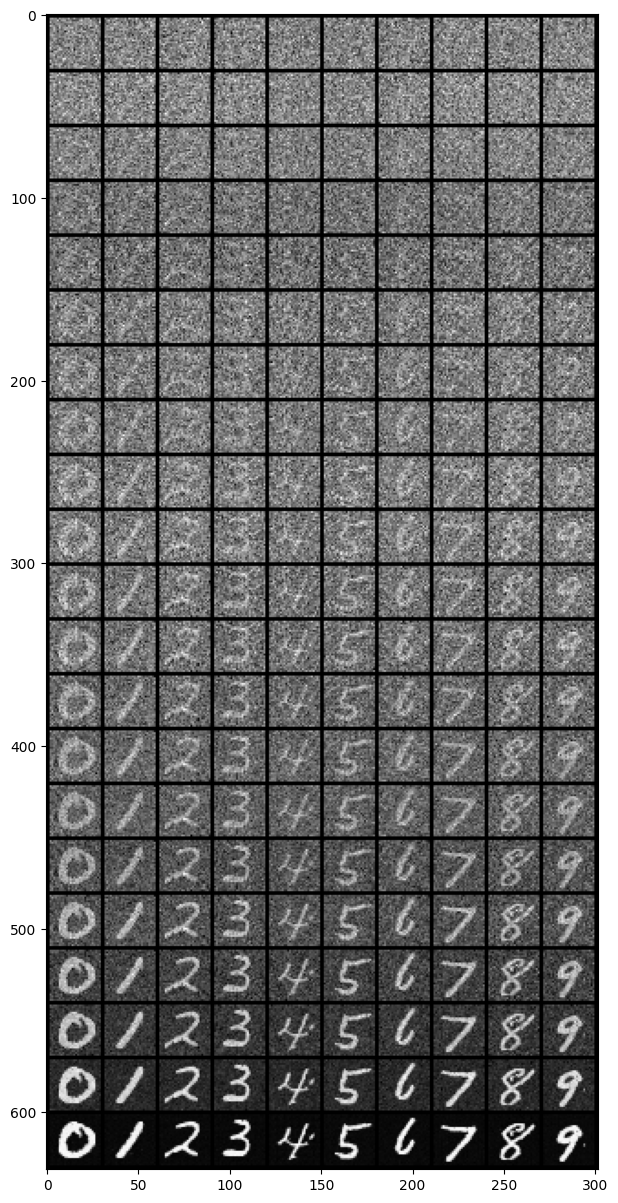

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5579,  ..., 0.5153, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0438,  ..., 0.0315, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5579,  ..., 0.5153, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0438,  ..., 0.0315, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5579,  ..., 0.5153, 0.0000, 0.

In [ ]:
generate_all_classes_steps(model)

In [ ]:
def generate_uncond(model, steps=T_MAX):
    """
    Generates images of random classes unconditionally.
    NOTE: Does not use classifier-free guidance (method='cfg'), although it could with scale = 0
    """

    labels = torch.full((BATCH_SIZE,), UNCOND_LABEL, dtype=torch.long, device=device)
    model.eval()
    noise = torch.randn(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
    diffused, _ = model.ddpm.backward(noise, model, labels, steps=steps)
    imgs = vutils.make_grid(diffused, normalize=True)
    plt.imshow(imgs.permute(1,2,0).cpu())
    plt.show()
    return imgs

# Driver code

In [ ]:
# TRAIN:
if CHECKPOINT:
  train_losses, img_list = load(model, optimizer)
  train(model, train_loader, criterion, optimizer, device, train_losses, img_list)
else:
  train(model, train_loader, criterion, optimizer, device)

# Loss curve

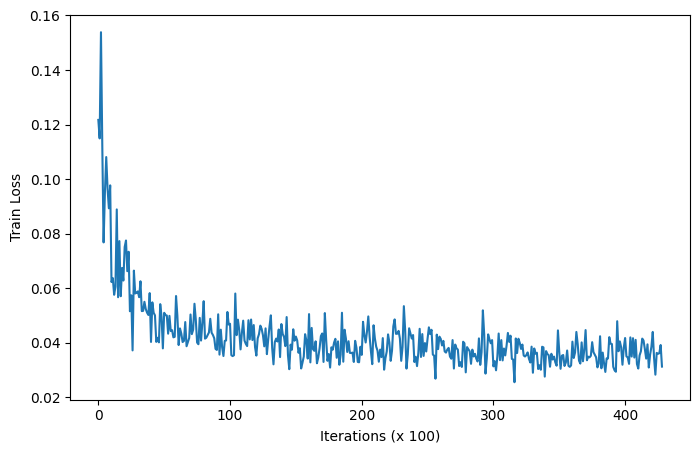

In [ ]:
with open(f'{path}/train_logs/{MODEL_NAME}_train_losses.json', 'r') as f:
    train_losses = json.load(f)

plt.figure(figsize=(8,5))
plt.plot(train_losses[1:]) # skip very first loss
plt.xlabel(f"Iterations (x {PRINT_EVERY})")
plt.ylabel("Train Loss")
plt.show()

# Visualization of diffusion

In [ ]:
img_list = torch.load(f'{path}/train_logs/{MODEL_NAME}_img_list.pt')

### Animation

In [ ]:
fig = plt.figure(figsize=(8,8)) # assuming batch size 64
plt.axis("off")
ims = [[plt.imshow(img.permute(1,2,0).cpu().numpy(), animated=True)] for img in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Side by side comparison

In [ ]:
real_img, _ = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_img.to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last saved img_list
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(img_list[-1].permute(1,2,0).cpu().numpy())
plt.show()